In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup
import time

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

## Top 200 Movies based on IMDB and No. of Reviews

In [2]:
options = Options()
options.add_argument("--headless")
options.add_argument("user-agent=Mozilla/5.0")

driver = webdriver.Chrome(options=options)
driver.get('https://www.imdb.com/chart/top/')
time.sleep(5)

soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

movies = []
movie_blocks = soup.find_all("li", class_="ipc-metadata-list-summary-item")

for item in movie_blocks:
    try:
        # title
        title_tag = item.find("h3")
        title = title_tag.text.strip() if title_tag else "N/A"

        # num of reviews
        vote_tag = item.select_one("span.ipc-rating-star--voteCount")
        votes_raw = vote_tag.text.strip() if vote_tag else "0"
        votes_raw = votes_raw.replace('\xa0', '').replace('(', '').replace(')', '')

        multiplier = 1
        if 'K' in votes_raw:
            multiplier = 1_000
            votes_raw = votes_raw.replace('K', '')
        elif 'M' in votes_raw:
            multiplier = 1_000_000
            votes_raw = votes_raw.replace('M', '')

        votes = int(float(votes_raw) * multiplier)

        movies.append((title, votes))

    except Exception as e:
        print(f"Error parsing row: {e}")


df = pd.DataFrame(movies, columns=["Title", "NumReviews"])

top_df = df

print(top_df.head())
print(f"Total movies saved: {len(top_df)}")

                         Title  NumReviews
0  1. The Shawshank Redemption     3000000
1             2. The Godfather     2100000
2           3. The Dark Knight     3000000
3     4. The Godfather Part II     1400000
4              5. 12 Angry Men      920000
Total movies saved: 250


In [3]:
print(top_df.head(200).to_string())

                                                                        Title  NumReviews
0                                                 1. The Shawshank Redemption     3000000
1                                                            2. The Godfather     2100000
2                                                          3. The Dark Knight     3000000
3                                                    4. The Godfather Part II     1400000
4                                                             5. 12 Angry Men      920000
5                            6. The Lord of the Rings: The Return of the King     2100000
6                                                         7. Schindler's List     1500000
7                                                             8. Pulp Fiction     2300000
8                        9. The Lord of the Rings: The Fellowship of the Ring     2100000
9                                          10. The Good, the Bad and the Ugly      849000
10        

## Top Foreign Movies

In [4]:
driver = webdriver.Chrome(options=options)
driver.get('https://www.imdb.com/list/ls052393071/')
time.sleep(5)

soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

movies = []
movie_blocks = soup.find_all("li", class_="ipc-metadata-list-summary-item")

for item in movie_blocks:
    try:
        #title
        title_tag = item.find("h3")
        title = title_tag.text.strip() if title_tag else "N/A"

        vote_tag = item.select_one("span.ipc-rating-star--voteCount")
        votes_raw = vote_tag.text.strip() if vote_tag else "0"
        votes_raw = votes_raw.replace('\xa0', '').replace('(', '').replace(')', '')

        multiplier = 1
        if 'K' in votes_raw:
            multiplier = 1_000
            votes_raw = votes_raw.replace('K', '')
        elif 'M' in votes_raw:
            multiplier = 1_000_000
            votes_raw = votes_raw.replace('M', '')

        votes = int(float(votes_raw) * multiplier)

        movies.append((title, votes))

    except Exception as e:
        print(f"Error parsing row: {e}")

df = pd.DataFrame(movies, columns=["Title", "NumReviews"])

top_foreign_df = df

print(top_foreign_df.head())
print(f"Total movies saved: {len(top_foreign_df)}")

                    Title  NumReviews
0  1. The Lives of Others      426000
1       2. Noi the Albino        9700
2             3. Das Boot      278000
3      4. Pan's Labyrinth      723000
4               5. Oldboy      675000
Total movies saved: 250


In [5]:
print(top_foreign_df.head(200).to_string())

                                              Title  NumReviews
0                            1. The Lives of Others      426000
1                                 2. Noi the Albino        9700
2                                       3. Das Boot      278000
3                                4. Pan's Labyrinth      723000
4                                         5. Oldboy      675000
5                                 6. Open Your Eyes       75000
6                          7. Max Manus: Man of War       31000
7                                        8. Respiro        5000
8                                   9. Run Lola Run      213000
9                                          10. Diva       15000
10   11. Spring, Summer, Fall, Winter... and Spring       89000
11               12. The Beat That My Heart Skipped       21000
12                                     13. The Wave      118000
13                           14. The Counterfeiters       48000
14                                  15. 

## Top 10 Directors

In [6]:
driver = webdriver.Chrome(options=options)
driver.get('https://www.imdb.com/list/ls026411399/')
time.sleep(5)

soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

directors = []

blocks = soup.find_all("li", class_="ipc-metadata-list-summary-item")

for item in blocks[:10]:
    try:
        name_tag = item.find("h3")
        name = name_tag.text.strip() if name_tag else "N/A"
        directors.append(name)
    except Exception as e:
        print("Error parsing director:", e)

top_dir_df = pd.DataFrame(directors, columns=["Director"])
print(top_dir_df)

                   Director
0      1. Christopher Nolan
1       2. Steven Spielberg
2      3. Quentin Tarantino
3        4. Martin Scorsese
4           5. Ridley Scott
5          6. David Fincher
6        7. Robert Zemeckis
7        8. Stanley Kubrick
8         9. Clint Eastwood
9  10. Francis Ford Coppola


In [7]:
print("Top 10 Directors")
for name in directors:
    print(f"{name}")

Top 10 Directors
1. Christopher Nolan
2. Steven Spielberg
3. Quentin Tarantino
4. Martin Scorsese
5. Ridley Scott
6. David Fincher
7. Robert Zemeckis
8. Stanley Kubrick
9. Clint Eastwood
10. Francis Ford Coppola


## Recommending Movies Based on Actors

### How my Recommending System Works

- The model recommends movies based on shared lead actors, using the top 3 actors listed for each film from IMDb.

- When a user selects a movie, the system finds others that share the most actors and ranks them based on how many appear in both films.

- The similarity between movies is measured using **cosine similarity**, which compares the overlap of actors represented in a **binary matrix**.

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
import re
import json

In [47]:
driver = webdriver.Chrome(options=options)
driver.get('https://www.imdb.com/chart/top/')
time.sleep(5)

soup = BeautifulSoup(driver.page_source, 'html.parser')
movie_blocks = soup.find_all("li", class_="ipc-metadata-list-summary-item")

movie_links = []
for item in movie_blocks:
    try:
        title_tag = item.find("h3")
        title = title_tag.text.strip() if title_tag else None
        link_tag = item.find("a", href=True)
        link = "https://www.imdb.com" + link_tag["href"].split("?")[0] if link_tag else None
        if title and link:
            movie_links.append((title, link))
    except:
        pass

driver.quit()

movie_data = []

for i, (title, link) in enumerate(movie_links[:20]):  # does 20 due to time
    try:
        driver = webdriver.Chrome(options=options)
        driver.get(link)
        time.sleep(3)

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        driver.quit()

        # Extract actor names from JSON-LD data
        script_tag = soup.find('script', type='application/ld+json')
        actors = []

        if script_tag:
            try:
                data = json.loads(script_tag.string)
                if 'actor' in data:
                    actors = [a['name'] for a in data['actor'][:3]]
            except Exception as e:
                print(f"JSON parse error for {title}: {e}")

        # save movie and actors
        row = [title] + actors
        row += [None] * (4 - len(row)) 
        movie_data.append(row)

        print(f"{i+1}. {title}: {actors}")

    except Exception as e:
        print(f"Error with {title}: {e}")
        movie_data.append([title, None, None, None])

# Save as DataFrame
actor_df = pd.DataFrame(movie_data, columns=["Title", "Actor1", "Actor2", "Actor3"])
print(f"\nSaved {len(actor_df)} movies with top 3 actors.")

1. 1. The Shawshank Redemption: ['Tim Robbins', 'Morgan Freeman', 'Bob Gunton']
2. 2. The Godfather: ['Marlon Brando', 'Al Pacino', 'James Caan']
3. 3. The Dark Knight: ['Christian Bale', 'Heath Ledger', 'Aaron Eckhart']
4. 4. The Godfather Part II: ['Al Pacino', 'Robert De Niro', 'Robert Duvall']
5. 5. 12 Angry Men: ['Henry Fonda', 'Lee J. Cobb', 'Martin Balsam']
6. 6. The Lord of the Rings: The Return of the King: ['Elijah Wood', 'Viggo Mortensen', 'Ian McKellen']
7. 7. Schindler's List: ['Liam Neeson', 'Ralph Fiennes', 'Ben Kingsley']
8. 8. Pulp Fiction: ['John Travolta', 'Uma Thurman', 'Samuel L. Jackson']
9. 9. The Lord of the Rings: The Fellowship of the Ring: ['Elijah Wood', 'Ian McKellen', 'Orlando Bloom']
10. 10. The Good, the Bad and the Ugly: ['Clint Eastwood', 'Eli Wallach', 'Lee Van Cleef']
11. 11. Forrest Gump: ['Tom Hanks', 'Robin Wright', 'Gary Sinise']
12. 12. The Lord of the Rings: The Two Towers: ['Elijah Wood', 'Ian McKellen', 'Viggo Mortensen']
13. 13. Fight Club: 

In [48]:
actor_df['Title'] = actor_df['Title'].apply(lambda x: re.sub(r'^\d+\.\s*', '', x))
actor_df.head()

,Title,Actor1,Actor2,Actor3
0,The Shawshank Redemption,Tim Robbins,Morgan Freeman,Bob Gunton
1,The Godfather,Marlon Brando,Al Pacino,James Caan
2,The Dark Knight,Christian Bale,Heath Ledger,Aaron Eckhart
3,The Godfather Part II,Al Pacino,Robert De Niro,Robert Duvall
4,12 Angry Men,Henry Fonda,Lee J. Cobb,Martin Balsam


In [49]:
actor_df = actor_df.fillna('')

actor_df['AllActors'] = actor_df[['Actor1', 'Actor2', 'Actor3']].values.tolist()

all_actors = sorted(set(actor for sublist in actor_df['AllActors'] for actor in sublist if actor))

actor_matrix = pd.DataFrame(0, index=actor_df['Title'], columns=all_actors)

for idx, row in actor_df.iterrows():
    for actor in row['AllActors']:
        if actor:
            actor_matrix.at[row['Title'], actor] = 1

similarity_matrix = cosine_similarity(actor_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=actor_df['Title'], columns=actor_df['Title'])

In [52]:
title_to_actors = dict(zip(actor_df['Title'], actor_df['AllActors']))

def recommend_movies_simple(input_title, top_n=5):
    if input_title not in title_to_actors:
        return f"Movie '{input_title}' not found."

    input_actors = set(title_to_actors[input_title])
    similarities = {}

    for title, actors in title_to_actors.items():
        if title == input_title:
            continue
        overlap = input_actors.intersection(set(actors))
        similarities[title] = len(overlap)

    # Sort by number of shared actors
    sorted_recs = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_recs[:top_n]

recommendations = recommend_movies_simple("The Lord of the Rings: The Two Towers")
for title, score in recommendations:
    print(f"{title} (shared: {score})")

The Lord of the Rings: The Return of the King (shared: 3)
The Lord of the Rings: The Fellowship of the Ring (shared: 2)
The Shawshank Redemption (shared: 0)
The Godfather (shared: 0)
The Dark Knight (shared: 0)


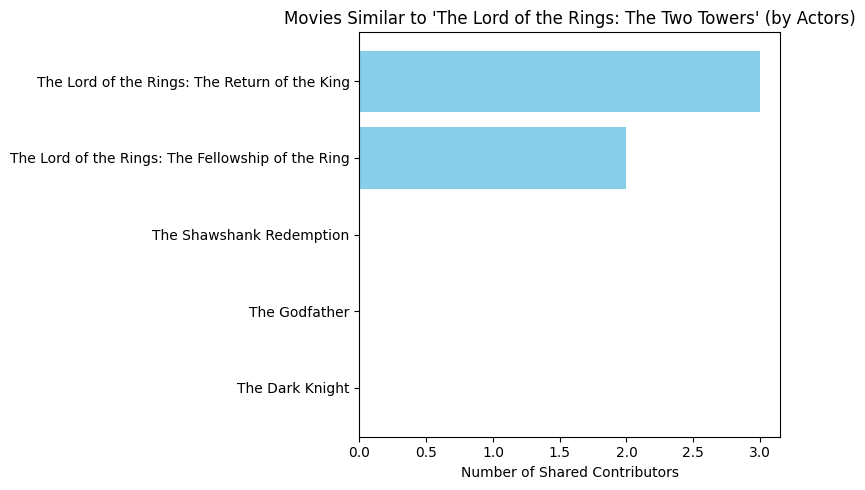

In [54]:
def plot_recommendations(input_title):
    recs = recommend_movies_simple(input_title)
    if isinstance(recs, str):
        print(recs)
        return

    titles = [title for title, score in recs]
    scores = [score for title, score in recs]

    plt.figure(figsize=(8, 5))
    plt.barh(titles, scores, color='skyblue')
    plt.xlabel("Number of Shared Contributors")
    plt.title(f"Movies Similar to '{input_title}' (by Actors)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_recommendations("The Lord of the Rings: The Two Towers")